<a href="https://colab.research.google.com/github/3048476752ksvl-lang/IB2AD0_Data_Science_GenerativeAI/blob/main/4_01_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [2]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [4]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [5]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [6]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.93


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

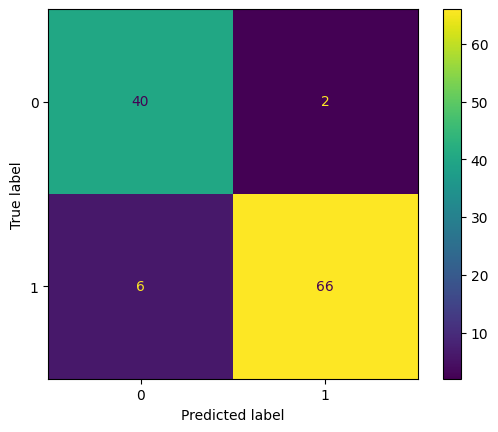

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.9
Micro-averaged Recall: 0.9
Micro-averaged F1-score: 0.9


Macro-averaged Precision: 0.89
Macro-averaged Recall: 0.91
Macro-averaged F1-score: 0.9


We can also see our tree:

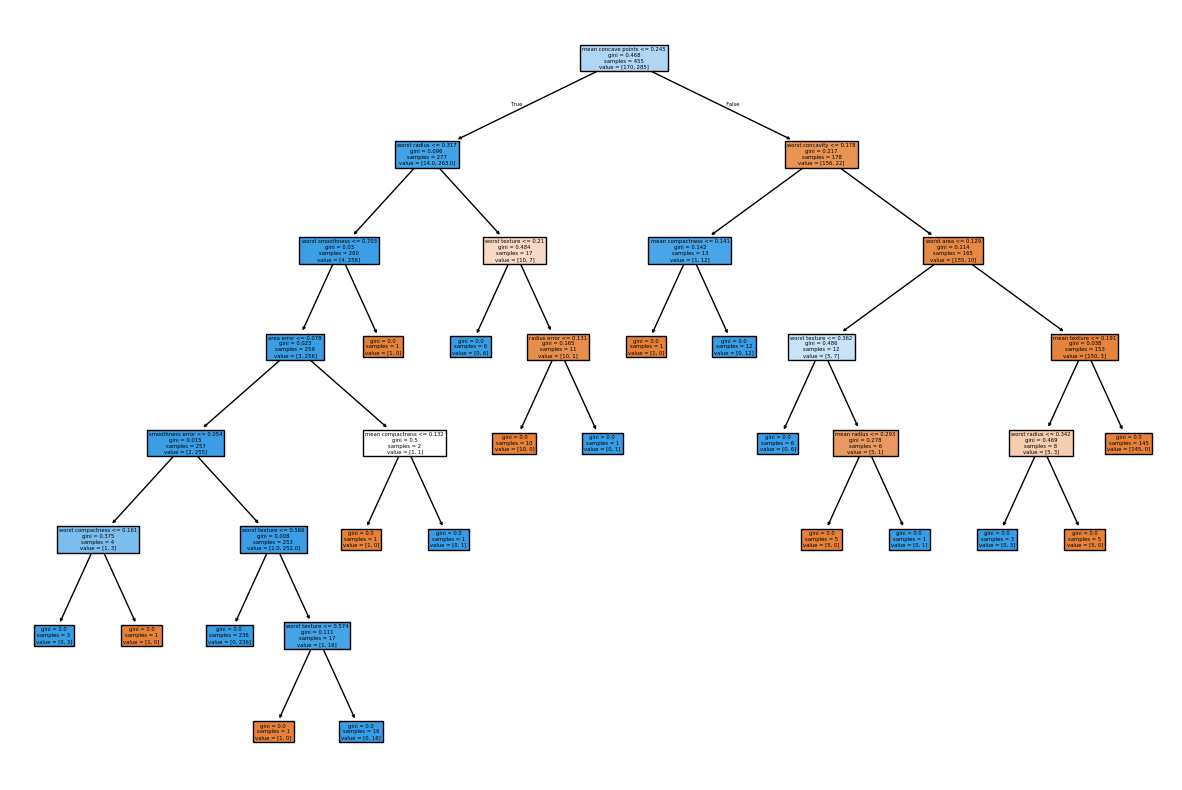

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a  uniform distribution between3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 7}


Now we can train the model again, but using these hyperparameters:

In [ ]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [ ]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.95


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.95
Micro-averaged Recall: 0.95
Micro-averaged F1-score: 0.95


Macro-averaged Precision: 0.94
Macro-averaged Recall: 0.95
Macro-averaged F1-score: 0.94




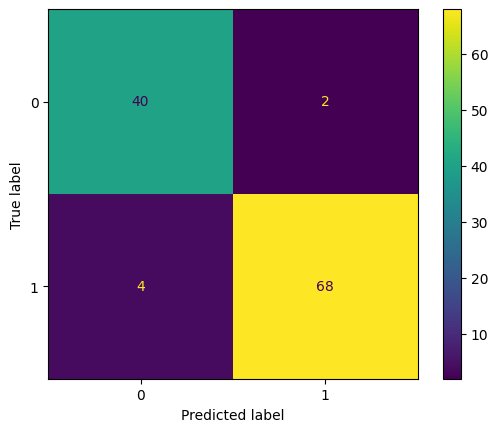

In [ ]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

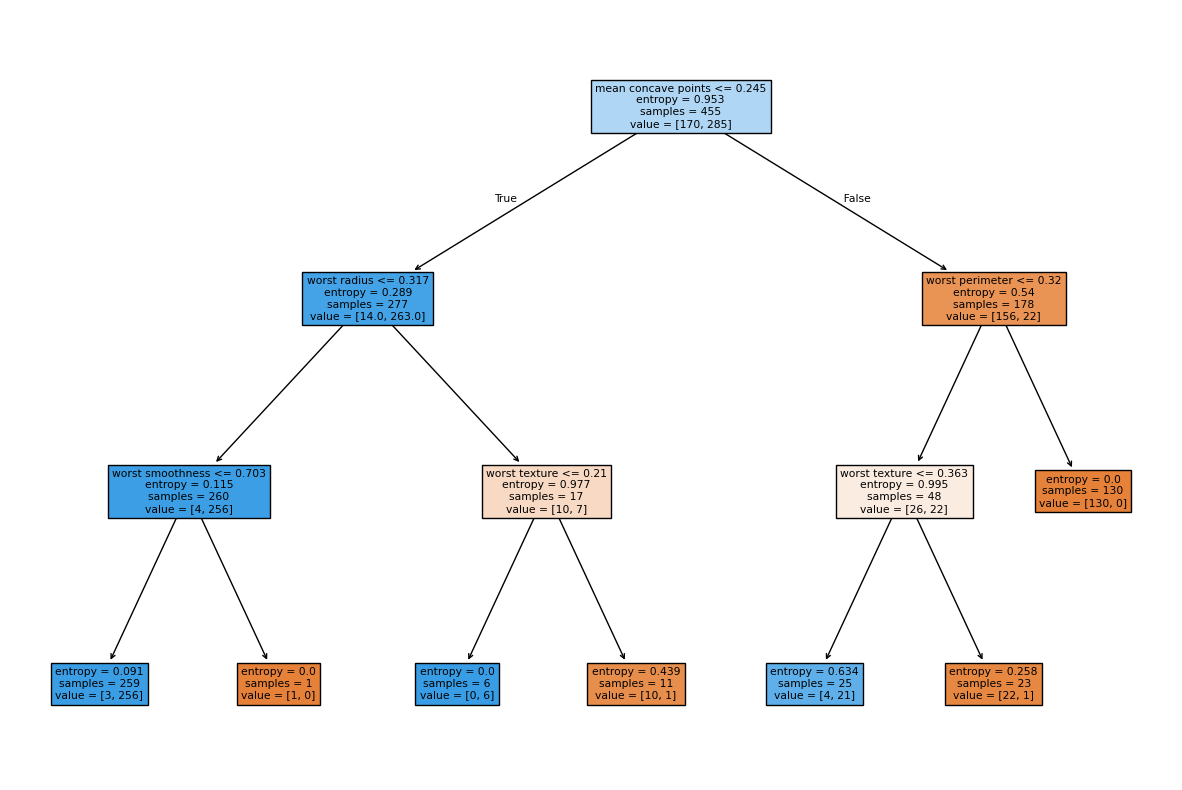

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





Training set: (455, 30)
Testing set: (114, 30)

OPTIMIZING FOR MACRO RECALL (Medical Priority)

Starting RandomizedSearchCV with scoring='recall_macro'...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters for recall optimization:
{'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_split': 4}

EVALUATION OF RECALL-OPTIMIZED MODEL

Accuracy: 0.947
Macro-average Recall: 0.948
Recall for Malignant (class 0): 0.952
Recall for Benign (class 1): 0.944
Macro-average F1: 0.944

Confusion Matrix:
[[40  2]
 [ 4 68]]

Detailed Classification Report:
              precision    recall  f1-score   support

   Malignant       0.91      0.95      0.93        42
      Benign       0.97      0.94      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



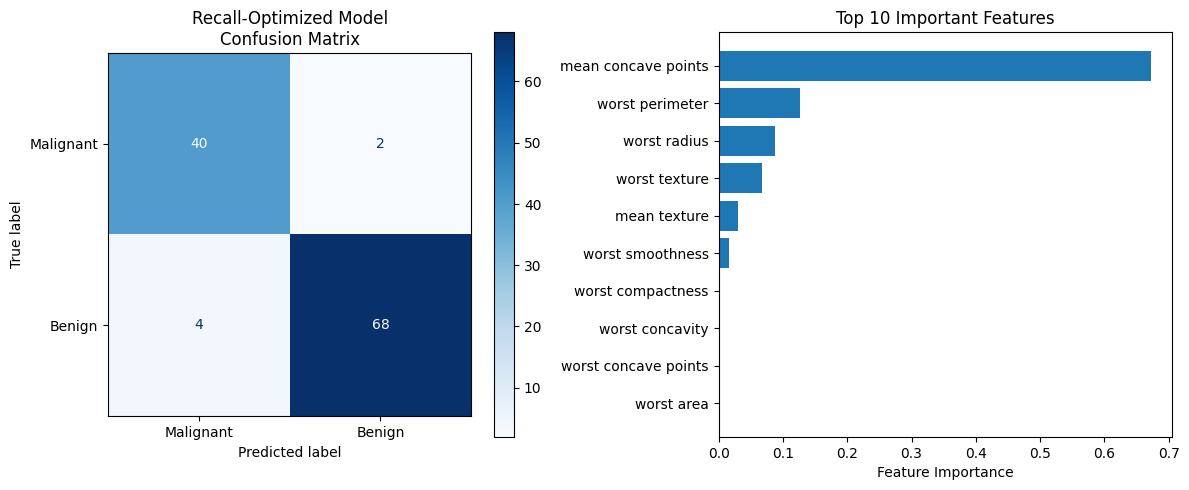


MEDICAL INTERPRETATION

True Negatives (TN): 40 - Correctly identified healthy patients
False Positives (FP): 2 - Healthy patients misdiagnosed as sick
False Negatives (FN): 4 - Sick patients missed (MOST CRITICAL)
True Positives (TP): 68 - Correctly identified sick patients

Sensitivity (Recall for sick): 0.944
Specificity (Recall for healthy): 0.952

MEDICAL IMPACT ANALYSIS:
- 4 sick patients would be missed (false negatives)
- 2 healthy patients would get unnecessary treatment (false positives)
- Model correctly identifies 68/72 = 94.4% of actual sick patients

COMPARISON: RECALL-OPTIMIZED vs F1-OPTIMIZED

F1-optimized model best parameters:
{'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 6}

----------------------------------------------------------------------
Metric                    Recall-Optimized     F1-Optimized        
----------------------------------------------------------------------
Accuracy                  0.947                0.93

In [14]:
# ============================
# TASK: Recall Optimization for Medical Diagnosis
# ============================

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from scipy.stats import randint
import matplotlib.pyplot as plt

# ============================
# 1. LOAD AND PREPARE DATA
# ============================

# Load breast cancer dataset
data = load_breast_cancer()

# Create feature DataFrame
X = pd.DataFrame(data.data, columns=data.feature_names)

# Normalize features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X = pd.DataFrame(X_normalized, columns=data.feature_names)

# Create target variable - FIXED: Use list instead of set
y = pd.DataFrame(data.target, columns=['class'])  # CHANGED: columns=['class'] instead of {'class'}
y = np.ravel(y)  # Convert to 1D array

# Alternative simpler approach:
# y = data.target  # This is already a 1D numpy array

# ============================
# 2. TRAIN-TEST SPLIT
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=1984,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

# ============================
# 3. DEFINE PARAMETER SPACE FOR RANDOM SEARCH
# ============================

tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),
    'min_samples_split': randint(3, 9),
    'max_features': ['sqrt', 'log2', None]
}

# ============================
# 4. OPTIMIZE FOR MACRO RECALL
# ============================

print("\n" + "="*60)
print("OPTIMIZING FOR MACRO RECALL (Medical Priority)")
print("="*60)

# Set scoring to macro recall (medical focus)
score_metric = 'recall_macro'

# Perform randomized search with recall optimization
clf_recall = RandomizedSearchCV(
    DecisionTreeClassifier(),
    tuned_parameters,
    cv=5,
    random_state=1984,
    scoring=score_metric,
    n_iter=20,
    refit=True,
    verbose=1  # Show progress
)

# Fit the model
print(f"\nStarting RandomizedSearchCV with scoring='{score_metric}'...")
clf_recall.fit(X_train, y_train)

# Get best parameters
print("\nBest parameters for recall optimization:")
print(clf_recall.best_params_)

# ============================
# 5. TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================

# Create and train model with best recall parameters
best_model_recall = DecisionTreeClassifier(**clf_recall.best_params_)
best_model_recall.fit(X_train, y_train)

# ============================
# 6. EVALUATE RECALL-OPTIMIZED MODEL
# ============================

print("\n" + "="*60)
print("EVALUATION OF RECALL-OPTIMIZED MODEL")
print("="*60)

# Make predictions
y_pred_recall = best_model_recall.predict(X_test)

# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred_recall)
recall_macro = recall_score(y_test, y_pred_recall, average='macro')
recall_per_class = recall_score(y_test, y_pred_recall, average=None)
f1_macro = f1_score(y_test, y_pred_recall, average='macro')

# Display results
print(f"\nAccuracy: {accuracy:.3f}")
print(f"Macro-average Recall: {recall_macro:.3f}")
print(f"Recall for Malignant (class 0): {recall_per_class[0]:.3f}")
print(f"Recall for Benign (class 1): {recall_per_class[1]:.3f}")
print(f"Macro-average F1: {f1_macro:.3f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_recall)
print(cm)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_recall,
                           target_names=['Malignant', 'Benign']))

# ============================
# 7. VISUALIZE CONFUSION MATRIX
# ============================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion matrix display
ConfusionMatrixDisplay.from_estimator(
    best_model_recall,
    X_test,
    y_test,
    display_labels=['Malignant', 'Benign'],
    cmap=plt.cm.Blues,
    ax=axes[0]
)
axes[0].set_title('Recall-Optimized Model\nConfusion Matrix')

# Feature importance (if available)
if hasattr(best_model_recall, 'feature_importances_'):
    importances = best_model_recall.feature_importances_
    indices = np.argsort(importances)[-10:]  # Top 10 features

    axes[1].barh(range(len(indices)), importances[indices])
    axes[1].set_yticks(range(len(indices)))
    axes[1].set_yticklabels([data.feature_names[i] for i in indices])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Top 10 Important Features')

plt.tight_layout()
plt.show()

# ============================
# 8. INTERPRETATION OF RESULTS
# ============================

print("\n" + "="*60)
print("MEDICAL INTERPRETATION")
print("="*60)

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()

print(f"\nTrue Negatives (TN): {tn} - Correctly identified healthy patients")
print(f"False Positives (FP): {fp} - Healthy patients misdiagnosed as sick")
print(f"False Negatives (FN): {fn} - Sick patients missed (MOST CRITICAL)")
print(f"True Positives (TP): {tp} - Correctly identified sick patients")

# Calculate critical metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nSensitivity (Recall for sick): {sensitivity:.3f}")
print(f"Specificity (Recall for healthy): {specificity:.3f}")

# Medical impact analysis
print(f"\nMEDICAL IMPACT ANALYSIS:")
print(f"- {fn} sick patients would be missed (false negatives)")
print(f"- {fp} healthy patients would get unnecessary treatment (false positives)")
print(f"- Model correctly identifies {tp}/{tp+fn} = {sensitivity:.1%} of actual sick patients")

# ============================
# 9. COMPARE WITH F1-OPTIMIZED MODEL
# ============================

# Also train an F1-optimized model for comparison
print("\n" + "="*60)
print("COMPARISON: RECALL-OPTIMIZED vs F1-OPTIMIZED")
print("="*60)

# Train F1-optimized model
clf_f1 = RandomizedSearchCV(
    DecisionTreeClassifier(),
    tuned_parameters,
    cv=5,
    random_state=1984,
    scoring='f1_macro',  # Different scoring metric
    n_iter=20,
    refit=True
)
clf_f1.fit(X_train, y_train)
best_model_f1 = DecisionTreeClassifier(**clf_f1.best_params_)
best_model_f1.fit(X_train, y_train)
y_pred_f1 = best_model_f1.predict(X_test)

# Calculate F1 model metrics
accuracy_f1 = accuracy_score(y_test, y_pred_f1)
recall_macro_f1 = recall_score(y_test, y_pred_f1, average='macro')
recall_per_class_f1 = recall_score(y_test, y_pred_f1, average=None)
f1_macro_f1 = f1_score(y_test, y_pred_f1, average='macro')

print(f"\nF1-optimized model best parameters:")
print(clf_f1.best_params_)

# Display comparison table
print("\n" + "-"*70)
print(f"{'Metric':<25} {'Recall-Optimized':<20} {'F1-Optimized':<20}")
print("-"*70)
print(f"{'Accuracy':<25} {accuracy:<20.3f} {accuracy_f1:<20.3f}")
print(f"{'Macro Recall':<25} {recall_macro:<20.3f} {recall_macro_f1:<20.3f}")
print(f"{'Recall (Malignant)':<25} {recall_per_class[0]:<20.3f} {recall_per_class_f1[0]:<20.3f}")
print(f"{'Recall (Benign)':<25} {recall_per_class[1]:<20.3f} {recall_per_class_f1[1]:<20.3f}")
print(f"{'Macro F1':<25} {f1_macro:<20.3f} {f1_macro_f1:<20.3f}")
print("-"*70)

# Determine which model is better for medical diagnosis
print("\nMEDICAL RECOMMENDATION:")
if recall_per_class[0] > recall_per_class_f1[0]:
    print("✓ Recall-optimized model is better for medical diagnosis")
    print(f"  - Identifies {recall_per_class[0]:.1%} vs {recall_per_class_f1[0]:.1%} of malignant cases")
    print(f"  - Reduces false negatives by {fn - confusion_matrix(y_test, y_pred_f1).ravel()[2]} cases")
else:
    print("✓ F1-optimized model is better for medical diagnosis")
    print(f"  - Identifies {recall_per_class_f1[0]:.1%} vs {recall_per_class[0]:.1%} of malignant cases")

# ============================
# 10. SAVE MODEL (Optional)
# ============================

print("\n" + "="*60)
print("MODEL DEPLOYMENT")
print("="*60)

print(f"\nBest Parameters for Medical Diagnosis:")
for param, value in clf_recall.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nExpected Performance:")
print(f"  - Will identify approximately {recall_per_class[0]:.1%} of malignant cases")
print(f"  - Overall accuracy: {accuracy:.1%}")
print(f"  - Critical misses (false negatives): {fn} out of {tp+fn} actual cases")

# Uncomment to save the model
# import joblib
# joblib.dump(best_model_recall, 'medical_diagnosis_model_recall_optimized.pkl')
# print("\nModel saved as 'medical_diagnosis_model_recall_optimized.pkl'")

print("\n" + "="*60)
print("TASK COMPLETED: Recall-optimized model trained and evaluated")
print("="*60)

